# Initial Setups

## autoreload

In [1]:
%load_ext autoreload
%autoreload 2

## dir setup

In [2]:
from dotenv import load_dotenv, find_dotenv
import os

this_file_path = os.path.dirname(os.path.abspath("__file__"))
# if script (not notebook)...
# project_dir = os.path.join(os.path.dirname(__file__), os.pardir)

# project directory
project_dir = os.path.join(this_file_path, os.pardir)

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

True

In [3]:
raw_data_dir = os.path.join(project_dir, os.environ.get("RAW_DATA_DIR"))
processed_data_dir = os.path.join(project_dir, os.environ.get("PROCESSED_DATA_DIR"))
interim_data_dir = os.path.join(project_dir, os.environ.get("INTERIM_DATA_DIR"))
wordvecs_data_dir = os.path.join(project_dir, os.environ.get("WORDVECS_DATA_DIR"))
figures_dir = os.path.join(project_dir, os.environ.get("FIGURES_DIR"))
reports_dir = os.path.join(project_dir, os.environ.get("REPORTS_DIR"))
cv_dir = os.path.join(project_dir, os.environ.get("CV_DIR"))
models_dir = os.path.join(project_dir, os.environ.get("MODELS_DIR"))

## imports

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
# import sweetviz as sv
# import utils

In [5]:
pd.set_option('max_rows', 200)

In [6]:
from tqdm import tqdm
tqdm.pandas()

/Users/hitoshinagano/.virtualenvs/tensorflow2/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## project imports

In [7]:
import sys
sys.path.insert(0, '..')

from src.features import *
from src.models import *

## spaCy imports

In [8]:
import spacy

port_nlp_fn = 'nilc50skip'
port_nlp_fp = os.path.join(wordvecs_data_dir, port_nlp_fn) 
port_nlp = spacy.load(port_nlp_fp)

espa_nlp_fn = 'suc30fast'
espa_nlp_fp = os.path.join(wordvecs_data_dir, espa_nlp_fn) 
espa_nlp = spacy.load(espa_nlp_fp)

### item_data.jl.gz
Note there are titles with the same texts, but with different item_id's.<br>
check with `item_data[item_data.duplicated(subset = ['title'], keep = False)].sort_values('title')`

Run this to reprocess a new `item_data.pkl` in `processed_data_dir`, for example with new embeddings (more dimensions on pre-trained, or custom embeddings)

In [14]:
item_data_fn = 'item_data.jl.gz'
item_data = pd.read_json(os.path.join(raw_data_dir, item_data_fn), lines=True)

#### item_domain used in the scoring

In [15]:
item_domain = item_data[['item_id', 'domain_id', 'category_id']]
item_domain_fn = 'item_domain.pkl'
item_domain_fp = os.path.join(processed_data_dir, item_domain_fn)
item_domain.to_pickle(item_domain_fp)

* MLB: Brasil
* MLM: Other countries

In [13]:
item_data.domain_id.str[:3].value_counts()

MLB    1723216
MLM     378210
Name: domain_id, dtype: int64

In [14]:
item_data['title_lower'] = item_data.title.str.lower()
item_data['lang_domain'] = item_data.domain_id.str[:3].replace({'MLM': 'es', 'MLB': 'pt'})
# domain_id contain NaNs. category_id does not
item_data['lang_category'] = item_data.category_id.str[:3].replace({'MLM': 'es', 'MLB': 'pt'})

In [15]:
item_data_unique = item_data[['title_lower', 'lang_category']].drop_duplicates()

In [16]:
def emb_vectors(x):
    if x.lang_category == 'pt':
        v = port_nlp(x.title_lower) 
    else:
        v = espa_nlp(x.title_lower)
        
    v_vector = v.vector
    vector_norm = v.vector_norm
    if vector_norm == 0:
        return np.zeros(v_vector.shape, dtype = np.float16)
    else:
        return (v_vector / vector_norm).astype(np.float16)

In [17]:
item_data_unique['title_embs'] = item_data_unique.progress_apply(emb_vectors, axis = 1)

100%|██████████| 1925776/1925776 [05:12<00:00, 6153.04it/s]


In [18]:
item_data = pd.merge(item_data, item_data_unique, how = 'left')

In [21]:
item_data_fn = 'item_data.pkl'
item_data_fp = os.path.join(processed_data_dir, item_data_fn)
item_data.to_pickle(item_data_fp)

In [22]:
item_data = item_data[['item_id', 'lang_category', 'title_embs']]

item_data_embs_only_fn = 'item_data_embs_only.pkl'
item_data_embs_only_fp = os.path.join(processed_data_dir, item_data_embs_only_fn)
item_data.to_pickle(item_data_embs_only_fp)

#### maybe cluster some of these domains into larger domains (smaller ones)? 

In [25]:
# item_data.groupby('domain_id').item_id.count().sort_values().head(20)

In [26]:
# item_data.groupby('domain_id').item_id.count().sort_values().tail(20)

## train_dataset.jl.gz

In [8]:
%%time
train = read_raw_save_processed('train_dataset.jl.gz', 'train_dataset.pkl')
# save_true_labels(train)

CPU times: user 3.47 s, sys: 1.29 s, total: 4.76 s
Wall time: 4.86 s


### 4% of the events correspond to the item bought

In [9]:
train.in_nav.value_counts(normalize = True)

False    0.959279
True     0.040721
Name: in_nav, dtype: float64

### 30% of the items bought show up in the navigation

In [10]:
train.groupby('seq').in_nav.any().value_counts(normalize = True)

False    0.706116
True     0.293884
Name: in_nav, dtype: float64

In [11]:
train.query("seq == 121")#.time_diff

,seq,item_bought,event_info,event_timestamp,event_type,time_diff,lang_seq,in_nav,in_nav_pred
2392969,121,388604,MINOXIDIL,2019-10-13 15:33:41,search,NaN,es,False,0.478697
2392970,121,388604,MINOXIDIL,2019-10-13 17:08:36,search,5695.0,es,False,0.478697
2392971,121,388604,429456,2019-10-13 17:09:04,view,28.0,es,False,0.478697
2392972,121,388604,429456,2019-10-13 17:09:43,view,39.0,es,False,0.478697
2392973,121,388604,429456,2019-10-13 17:10:37,view,54.0,es,False,0.478697
2392974,121,388604,MINOXIDIL,2019-10-13 17:10:38,search,1.0,es,False,0.478697
2392975,121,388604,625179,2019-10-13 17:10:46,view,8.0,es,False,0.478697
2392976,121,388604,MINOXIDIL,2019-10-13 17:10:58,search,12.0,es,False,0.478697
2392977,121,388604,410942,2019-10-13 17:11:45,view,47.0,es,False,0.478697
2392978,121,388604,410942,2019-10-13 17:12:29,view,44.0,es,False,0.478697


### 49% of the domain_id of items bought show up in the navigated domain_id's

In [12]:
from matplotlib_venn import venn2

In [13]:
item_domain_fn = 'item_domain.pkl'
item_domain_fp = os.path.join(processed_data_dir, item_domain_fn)
item_domain = pd.read_pickle(item_domain_fp)

#### prepare `bought_domain_id` & `nav_domain_id` for seq's in train

In [14]:
train = pd.merge(train, item_domain[['item_id', 'domain_id']], how = 'left', 
                 left_on = 'item_bought', right_on = 'item_id')

train.rename(columns = {'domain_id': 'bought_domain_id'}, inplace = True)

train = pd.merge(train, item_domain[['item_id', 'domain_id']], how = 'left', 
                 left_on = 'event_info', right_on = 'item_id')

train.rename(columns = {'domain_id': 'nav_domain_id'}, inplace = True)

train.drop(['item_id_x', 'item_id_y'], axis = 1, inplace = True)

train['in_nav_domain'] = train.bought_domain_id == train.nav_domain_id

In [14]:
train.groupby('seq').in_nav_domain.any().value_counts(normalize = True)

False    0.506594
True     0.493406
Name: in_nav_domain, dtype: float64

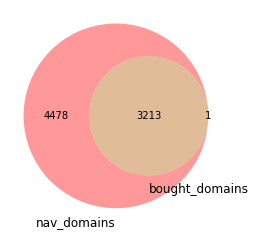

In [16]:
nav_domains = set(train.nav_domain_id.unique())
bought_domains = set(train.bought_domain_id.unique())

venn2([nav_domains, bought_domains], ('nav_domains', 'bought_domains'))
plt.show()

### top 10 bought domains
```
MLB-CELLPHONES                 25070
MLB-SNEAKERS                   14608
MLB-SUPPLEMENTS                 9562
MLB-HEADPHONES                  9053
MLB-SMARTWATCHES                7963
MLB-DOLLS                       4915
MLB-VIDEO_GAMES                 4637
MLM-HEADPHONES                  4603
MLB-BOOTS_AND_BOOTIES           4325
MLB-STREAMING_MEDIA_DEVICES     4104
```

In [17]:
top10_bought_domains = train.groupby('seq').bought_domain_id.last().value_counts().head(10)
top10_bought_domains

MLB-CELLPHONES                 25070
MLB-SNEAKERS                   14608
MLB-SUPPLEMENTS                 9562
MLB-HEADPHONES                  9053
MLB-SMARTWATCHES                7963
MLB-DOLLS                       4915
MLB-VIDEO_GAMES                 4637
MLM-HEADPHONES                  4603
MLB-BOOTS_AND_BOOTIES           4325
MLB-STREAMING_MEDIA_DEVICES     4104
Name: bought_domain_id, dtype: int64

### quantity of items in each of the top10 bought domains
```
MLB-CELLPHONES                 38390
MLB-SNEAKERS                   32636
MLB-SUPPLEMENTS                22351
MLB-VIDEO_GAMES                12742
MLB-HEADPHONES                 11328
MLB-DOLLS                      10023
MLB-SMARTWATCHES                8721
MLB-BOOTS_AND_BOOTIES           8564
MLM-HEADPHONES                  5731
MLB-STREAMING_MEDIA_DEVICES     4807
```

In [18]:
item_domain[item_domain.domain_id.isin(top10_bought_domains.index)].domain_id.value_counts()

MLB-CELLPHONES                 38390
MLB-SNEAKERS                   32636
MLB-SUPPLEMENTS                22351
MLB-VIDEO_GAMES                12742
MLB-HEADPHONES                 11328
MLB-DOLLS                      10023
MLB-SMARTWATCHES                8721
MLB-BOOTS_AND_BOOTIES           8564
MLM-HEADPHONES                  5731
MLB-STREAMING_MEDIA_DEVICES     4807
Name: domain_id, dtype: int64

#### build `target_items_by_nav_domain`

In [15]:
unique_items_by_domain_id = item_domain.groupby('domain_id').item_id.unique()
unique_items_by_domain_id = unique_items_by_domain_id.reset_index()

In [16]:
unique_bought_doms_by_nav_doms = train.groupby('nav_domain_id').bought_domain_id.unique()
unique_bought_doms_by_nav_doms = unique_bought_doms_by_nav_doms.explode()
unique_bought_doms_by_nav_doms = unique_bought_doms_by_nav_doms.reset_index()

In [17]:
target_items_by_nav_domain = pd.merge(unique_bought_doms_by_nav_doms, unique_items_by_domain_id, how = 'left',
                                         left_on = 'bought_domain_id', right_on = 'domain_id')

target_items_by_nav_domain = target_items_by_nav_domain.groupby('nav_domain_id').item_id.agg(list)

target_items_by_nav_domain = target_items_by_nav_domain.apply(lambda x: np.concatenate(x, axis = None))

# target_items_by_nav_domain = target_items_by_nav_domain.reset_index()

In [19]:
target_items_by_nav_domain = target_items_by_nav_domain.reset_index()

In [21]:
target_items_by_nav_domain['lang'] = target_items_by_nav_domain.nav_domain_id.str[:3].replace({'MLM': 'es', 'MLB': 'pt'})

In [23]:
for lang in ['pt', 'es']:
    target_items_by_nav_domain_fn = lang + '_target_items_by_nav_domain.pkl'
    target_items_by_nav_domain_fp = os.path.join(processed_data_dir, target_items_by_nav_domain_fn)
    target_items_by_nav_domain[target_items_by_nav_domain.lang == lang].to_pickle(target_items_by_nav_domain_fp)

## test_dataset.jl.gz

In [8]:
%%time
test = read_raw_save_processed('test_dataset.jl.gz', 'test_dataset.pkl')

CPU times: user 1.23 s, sys: 423 ms, total: 1.65 s
Wall time: 1.67 s


In [9]:
target_items_by_nav_domain_fn = 'target_items_by_nav_domain.pkl'
target_items_by_nav_domain_fp = os.path.join(processed_data_dir, target_items_by_nav_domain_fn)
target_items_by_nav_domain = pd.read_pickle(target_items_by_nav_domain_fp)

In [10]:
test

,seq,event_info,event_timestamp,event_type,time_diff,lang_seq
0,58988,LENOVO PB2 650,2019-10-26 01:42:17,search,NaN,NaN
1,169158,1958786,2019-10-07 20:49:29,view,NaN,pt
2,132866,278718,2019-10-23 20:29:55,view,NaN,pt
3,46124,1331730,2019-10-28 10:47:10,view,NaN,pt
4,145896,LUCCAS NETO,2019-10-12 12:06:36,search,NaN,NaN
...,...,...,...,...,...,...
5187749,64486,478355,2019-10-01 04:26:02,view,44.0,pt
5187750,64486,478355,2019-10-01 04:26:21,view,19.0,pt
5187751,64486,478355,2019-10-01 04:26:29,view,8.0,pt
5187752,64486,478355,2019-10-01 04:26:44,view,15.0,pt


_____

* test_dataset.jl.gz
* sample_submission.csv

### other train feature engineerings (estimate prob of in_nav purchase)

In [51]:
# t = train.groupby('seq').in_nav.any().reset_index()
# train.drop('in_nav', axis = 1, inplace = True)
# train = pd.merge(train, t, how = 'left')

In [10]:
# train['time_diff_intra_session'] = [td if td < 1800 else 0 for td in train.time_diff]

In [55]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import cross_val_score

# lr = LogisticRegression()
# rf = RandomForestClassifier(max_depth = 7, min_samples_split = 0.001)

In [57]:
# t1 = train.groupby('seq').event_type.value_counts().unstack().fillna(0)
# t2 = train.groupby('seq').agg({'in_nav': np.any, 'lang_seq': 'first'})
# t4 = train[train.event_type == 'view'].groupby('seq').event_info.value_counts(normalize = True)
# t4.name = 'mode_freq'
# t4 = t4.reset_index()
# t4 = t4.groupby('seq').mode_freq.first()

# t = pd.concat([t1, t2, t4], axis = 1)

# t.drop(columns = 'buy', inplace = True)
# t['lang_seq'] = t.lang_seq.replace({'pt': 0, 'es': 1}).fillna(0)

# t = t.fillna(-100)

In [60]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, classification_report

# X, y = t[['search', 'view', 'lang_seq', 'mode_freq']], t.in_nav

In [79]:
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# params = {'n_estimators': [50, 100, 200], 'max_depth': [5, 8, 11, 14], 'min_samples_split': [0.01, 0.001, 0.0001]}

# gs = RandomizedSearchCV(RandomForestClassifier(), param_distributions = params, scoring = 'f1', verbose = 1, n_jobs = -1, cv = 3, n_iter = 6)

# gs.fit(X, y)

# rf_best = gs.best_estimator_

In [69]:
# X_train, X_test, y_train, y_test = train_test_split(X, y)

In [80]:
# rf_best
# RandomForestClassifier(max_depth=14, min_samples_split=0.0001, n_estimators=200)

RandomForestClassifier(max_depth=14, min_samples_split=0.0001, n_estimators=200)

In [84]:
# rf_best.fit(X_train, y_train)

# y_pred = rf_best.predict(X_test)

# confusion_matrix(y_test, y_pred)

# print(classification_report(y_test, y_pred))

In [103]:
# rf_best.fit(X, y)

# t['in_nav_pred'] = rf_best.predict_proba(X)[:, 1]

# t.reset_index(inplace = True)

# train = pd.merge(train, t[['seq', 'in_nav_pred']], how = 'left', left_on = 'seq', right_on = 'seq')

# processed_fn = 'train_dataset.pkl'
# processed_fp = os.path.join(processed_data_dir, processed_fn)
# train.to_pickle(processed_fp)

## other train explorations